In [15]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Import all required metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 


from tqdm import tqdm


In [2]:
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error (SMAPE) for numpy arrays."""

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # handle zero denominator
    return 100 * np.mean(diff)

In [3]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load your dataset
data = pd.read_csv(r'/kaggle/input/train-embedding/all_embeddings_merged.csv')

In [5]:
# Extract embedding columns as numpy arrays and concatenate them
gemma_cols = [f'gemma_{i}' for i in range(768)]
laion_text_cols = [f'laion_text_{i}' for i in range(768)]
laion_image_cols = [f'laion_image_{i}' for i in range(768)]

# Create fused features by concatenating embeddings horizontally
fused_features = np.hstack([
    data[gemma_cols].values,
    data[laion_text_cols].values,
    data[laion_image_cols].values
])

prices = data['price'].values


In [6]:
# Standard Scale the concatenated features
scaler = StandardScaler()
fused_features_scaled = scaler.fit_transform(fused_features)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


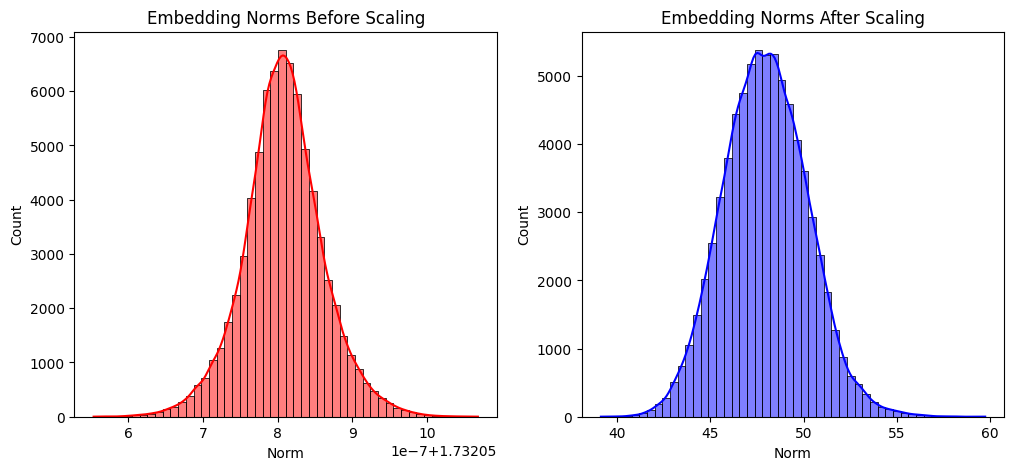

In [7]:
# Visualize norms before scaling
norms_before = np.linalg.norm(fused_features, axis=1)
# Visualize norms after scaling
norms_after = np.linalg.norm(fused_features_scaled, axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(norms_before, bins=50, kde=True, color='red')
plt.title("Embedding Norms Before Scaling")
plt.xlabel("Norm")

plt.subplot(1, 2, 2)
sns.histplot(norms_after, bins=50, kde=True, color='blue')
plt.title("Embedding Norms After Scaling")
plt.xlabel("Norm")

plt.show()

In [8]:
# TARGET TRANSFORMATION: Apply Log(1+y) to the prices for training
y_transformed = np.log1p(prices)

In [9]:
# Split scaled features, transformed targets (y), and ORIGINAL targets
X_train, X_val, y_train, y_val, prices_train_original, prices_val_original = train_test_split(
    fused_features_scaled, y_transformed, prices , test_size=0.20, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Validation Samples: {X_val.shape[0]}")


Training Samples: 60000, Validation Samples: 15000


In [10]:
# Neural network 
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(256, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(0.1)

        self.fc5 = nn.Linear(64, 32)
        self.dropout5 = nn.Dropout(0.1)

        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        x = self.dropout5(x)
        x = self.out(x)
        return x




In [11]:
# --- Training Function with Full Metric Reporting ---
def train_and_save_nn(X_train, y_train, X_val, y_val, prices_val_original, scaler, input_dim, model_path='best_nn_model.pth', epochs=50, batch_size=256, patience=8):
    """
    Trains the SimpleNN model using a single train/validation split,
    applies early stopping, and saves the best model state.
    Returns the best validation SMAPE score.
    """
    
    # Create PyTorch datasets and loaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                  torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and criterion
    model = SimpleNN(input_dim=input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-5)
    
    # Using L1Loss (MAE) as the training objective
    criterion = nn.L1Loss() 

    best_val_loss = float('inf')
    best_model_state = None
    best_val_smape = float('inf')
    epochs_no_improve = 0

    print(f"Starting training on {len(X_train)} samples with early stopping (patience={patience})...")
    print("-" * 100)
    print(f"{'Epoch':<5} | {'Train Loss (Log MAE)':<20} | {'Val Loss (Log MAE)':<20} | {'SMAPE (%)':<10} | {'R2':<6} | {'MAE ($)':<10} | {'RMSE ($)':<10}")
    print("-" * 100)
    

    for epoch in range(epochs):
        model.train()
        train_losses = []
        # Use simple list comprehension instead of tqdm for environment compatibility
        for xb, yb in train_loader: 
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Validation phase
        model.eval()
        val_losses = []
        val_preds_log = [] # Predictions in LOG scale
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())
                val_preds_log.extend(preds.cpu().numpy()) # Collect log predictions

        avg_val_loss = np.mean(val_losses)
        
        # --- Metric Calculation on Original Scale ---
        
        # 1. Convert predictions from log scale back to original scale (price)
        val_preds_log = np.array(val_preds_log).flatten()
        
        # Clip values before expm1 to prevent numerical overflow and ensure meaningful positive prices
        val_preds_log = np.clip(val_preds_log, -10, None)
        
        # Inverse log transform: exp(x) - 1
        val_preds_original = np.expm1(val_preds_log) 
        # Ensure final predicted prices are non-negative
        val_preds_original[val_preds_original < 0] = 0 
        
        # 2. Calculate Metrics using Inverse-Transformed Predictions and ORIGINAL Prices
        
        # SMAPE (Target Metric)
        val_smape = smape(prices_val_original, val_preds_original)
        
        # R-squared (Explained Variance)
        val_r2 = r2_score(prices_val_original, val_preds_original)
        
        # MAE (Mean Absolute Error in $ units)
        val_mae = mean_absolute_error(prices_val_original, val_preds_original)
        
        # RMSE (Root Mean Squared Error in $ units)
        val_rmse = np.sqrt(mean_squared_error(prices_val_original, val_preds_original))

        # Print all metrics for the current epoch
        print(
            f"{epoch+1:<5} | {avg_train_loss:<20.4f} | {avg_val_loss:<20.4f} | {val_smape:<10.2f} | {val_r2:<6.4f} | {val_mae:<10.2f} | {val_rmse:<10.2f}"
        )

        # --- Early Stopping Check ---
        # We continue to use the validation loss (Log MAE) as the stopping criteria
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            
            best_model_state = model.state_dict()
            best_metrics = {
                'SMAPE': val_smape, 
                'R2': val_r2, 
                'MAE': val_mae, 
                'RMSE': val_rmse
            }
            
            
            # Save the best model state based on validation loss
            full_state_dict = {
                'model_state_dict': best_model_state,
                'scaler': scaler,  # Include the fitted scaler object here
                'input_dim': input_dim # Optional: Save input dimension for safety
            }
        
            # 3. Save the entire bundled dictionary to the .pth file
            torch.save(full_state_dict, model_path)
            print(f"*** FULL MODEL and SCALER successfully bundled and saved to {model_path} ***")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("\nEarly stopping triggered: Validation loss (Log MAE) did not improve.")
                break
    
    

    if os.path.exists(model_path):
        # We need weights_only=False and to specify the pickle module 
        # because the file contains the StandardScaler object (non-weight data).
        checkpoint = torch.load(
            model_path, 
            map_location=device, 
            weights_only=False, 
            pickle_module=pickle
        )
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Warning: Best model file not found for final load.")
    
    print("-" * 100)
    print(f"--- Training Complete ---")
    print(f"Best Validation Loss (Log MAE): {best_val_loss:.4f}")
    print(f"Final Best Metrics on Validation Set: {best_metrics}")
    
    return best_metrics

In [16]:
# --- Execution ---

input_dim = X_train.shape[1]  
final_val_metrics = train_and_save_nn(
    X_train, y_train, X_val, y_val, prices_val_original, scaler,
    input_dim=input_dim, 
    epochs=50, 
    batch_size=512, 
    patience=8,
    model_path='best_nn_model.pth' # The file path where the bundled model/scaler will be saved
)

Starting training on 60000 samples with early stopping (patience=8)...
----------------------------------------------------------------------------------------------------
Epoch | Train Loss (Log MAE) | Val Loss (Log MAE)   | SMAPE (%)  | R2     | MAE ($)    | RMSE ($)  
----------------------------------------------------------------------------------------------------
1     | 0.7519               | 0.5836               | 57.89      | 0.2519 | 13.00      | 27.00     
*** FULL MODEL and SCALER successfully bundled and saved to best_nn_model.pth ***
2     | 0.5769               | 0.5404               | 54.08      | 0.2941 | 12.31      | 26.22     
*** FULL MODEL and SCALER successfully bundled and saved to best_nn_model.pth ***
3     | 0.5430               | 0.5325               | 53.40      | 0.3251 | 12.13      | 25.64     
*** FULL MODEL and SCALER successfully bundled and saved to best_nn_model.pth ***
4     | 0.5158               | 0.5146               | 51.63      | 0.3679 | 11.75